<a href="https://colab.research.google.com/github/anky19698/Cricket-Score-Predictor/blob/main/Score_Predictor_IPL_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Data From Cricsheet

In [ ]:
# Get the T20 Ball by Ball Data

import requests
import zipfile
import io
import os
import pandas as pd
import glob
import os
import numpy as np

url = 'https://cricsheet.org/downloads/ipl_csv2.zip'

response = requests.get(url)
destination_folder = 't20_male_csv'

if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
        print('success')
else:
    print('failed')


success


In [ ]:
files = glob.glob('/content/t20_male_csv/[0-9]*.csv')
all_files = []
for file in files:
  filename = os.path.basename(file)
  # print(filename[:-4])
  if 'info' not in filename:
    # print(filename)
    all_files.append(file)

df = pd.concat((pd.read_csv(f, header = 0) for f in all_files))

# exporting final csv without super overs data

df = df[df['innings'] < 3]

df.to_csv('ipl_ball_by_ball.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Feature Engineering

In [ ]:
data = pd.read_csv('/content/ipl_ball_by_ball.csv')

In [ ]:
# Excluding Target Match from Dataset

# MI vs CSK IPL 2019 Final => Match ID: 1181768

# RCB vs SRH IPL 2016 Final => Match ID: 981019

# MI vs DC IPL 2020 Final => Match ID: 1237181

data = data[~data.match_id.isin([1181768, 981019, 1237181])]

In [ ]:
batter_runs = data.groupby('striker')['runs_off_bat'].sum().reset_index().rename(columns = {'runs_off_bat': 'runs'})

In [ ]:
batter_balls_faced = data.groupby('striker')['match_id'].count().reset_index().rename(columns = {'match_id': 'balls'})

In [ ]:
batter = pd.merge(batter_runs, batter_balls_faced, on='striker')

In [ ]:
batter

,striker,runs,balls
0,A Ashish Reddy,280,196
1,A Badoni,399,325
2,A Chandila,4,7
3,A Chopra,53,75
4,A Choudhary,25,20
...,...,...,...
633,Yashpal Singh,47,67
634,Younis Khan,3,7
635,Yudhvir Singh,1,2
636,Yuvraj Singh,2712,2181


In [ ]:
batter['striker_SR'] = 100*(batter['runs'] / batter['balls'])

batter

,striker,runs,balls,striker_SR
0,A Ashish Reddy,280,196,142.857143
1,A Badoni,399,325,122.769231
2,A Chandila,4,7,57.142857
3,A Chopra,53,75,70.666667
4,A Choudhary,25,20,125.000000
...,...,...,...,...
633,Yashpal Singh,47,67,70.149254
634,Younis Khan,3,7,42.857143
635,Yudhvir Singh,1,2,50.000000
636,Yuvraj Singh,2712,2181,124.346630


In [ ]:
batter_SR = batter.set_index('striker')['striker_SR'].to_dict()

In [ ]:
batter_SR

{'A Ashish Reddy': 142.85714285714286,
 'A Badoni': 122.76923076923076,
 'A Chandila': 57.14285714285714,
 'A Chopra': 70.66666666666667,
 'A Choudhary': 125.0,
 'A Dananjaya': 80.0,
 'A Flintoff': 108.77192982456141,
 'A Kumble': 71.42857142857143,
 'A Manohar': 134.54545454545453,
 'A Mishra': 86.5909090909091,
 'A Mithun': 130.76923076923077,
 'A Mukund': 82.6086956521739,
 'A Nehra': 65.07936507936508,
 'A Nortje': 107.14285714285714,
 'A Singh': 20.0,
 'A Symonds': 124.71190781049937,
 'A Tomar': 50.0,
 'A Uniyal': 57.14285714285714,
 'A Zampa': 60.0,
 'AA Bilakhia': 78.4090909090909,
 'AA Chavan': 109.09090909090908,
 'AA Jhunjhunwala': 99.54128440366972,
 'AA Noffke': 75.0,
 'AB Agarkar': 111.87499999999999,
 'AB Barath': 97.67441860465115,
 'AB Dinda': 52.0,
 'AB McDonald': 119.41747572815532,
 'AB de Villiers': 148.48833861215087,
 'AC Blizzard': 131.86813186813185,
 'AC Gilchrist': 133.05466237942122,
 'AC Thomas': 105.26315789473684,
 'AC Voges': 126.57342657342659,
 'AD Hal

In [ ]:
data = data.fillna(0)

# Striker's Strike Rate
data['striker_SR'] = data['striker'].apply(lambda x: batter_SR[x])



# Total Runs

data['total_runs'] = data['runs_off_bat'] + data['extras']

# Dot Ball

data['is_dot'] = data['total_runs'].apply(lambda x: 1 if x==0 else 0)

# Dots Till Current Ball

data['cum_dots'] = data.groupby(['match_id', 'innings'])['is_dot'].apply(lambda x: x.cumsum())

# Total Runs per innings

data['inning_runs'] = data.groupby(['match_id', 'innings'])['total_runs'].transform('sum')

# Total Runs per innings


# Runs Scored till current ball

data['cum_runs'] = data.groupby(['match_id', 'innings'])['total_runs'].apply(lambda x: x.cumsum())

# Players Dismissed

data['player_dismissed'] = data['player_dismissed'].apply(lambda x: 1 if type(x) == type('str') else 0)

# Total Wickets per innings

data['inning_wkts'] = data.groupby(['match_id', 'innings'])['player_dismissed'].transform('sum')

# Wickets Till Current Ball

data['cum_wkts'] = data.groupby(['match_id', 'innings'])['player_dismissed'].apply(lambda x: x.cumsum())


# Prev 5 Run Rate

tmp = data.groupby(['match_id', 'innings'])['total_runs'].rolling(min_periods=1, window=30).sum().reset_index()
# tmp
data['prev_5_runs'] = tmp['total_runs'].to_list()

data['prev_5_run_rate'] = data['prev_5_runs']*6 / 30


# prev 5 Boundaries

data['prev_5_boundary'] = np.where(data['total_runs'] > 3, 1, 0)

tmp = data.groupby(['match_id', 'innings'])['prev_5_boundary'].rolling(min_periods=1, window=30).sum().reset_index()

data['prev_5_boundary'] = tmp['prev_5_boundary'].to_list()

In [ ]:
data['ball'] = data['ball'].astype('str')
data['overs'] = data['ball'].str[:]
data['over'] = data['ball'].str[:1]
data['ball'] = data['ball'].str[-1:]

In [ ]:
data.overs = data.overs.astype(float)
data.over = data.over.astype(int)
data.ball = data.ball.astype(int)


In [ ]:
data['balls_left'] = 120 - data['over']*6 - data['ball']

data['balls_bowled'] = data['over']*6 + data['ball']


In [ ]:
# Current Run Rate

data['run_rate'] = data['cum_runs'] * 6 / data['balls_bowled']

data['projected_score'] = data['run_rate'] * 20

<Axes: >

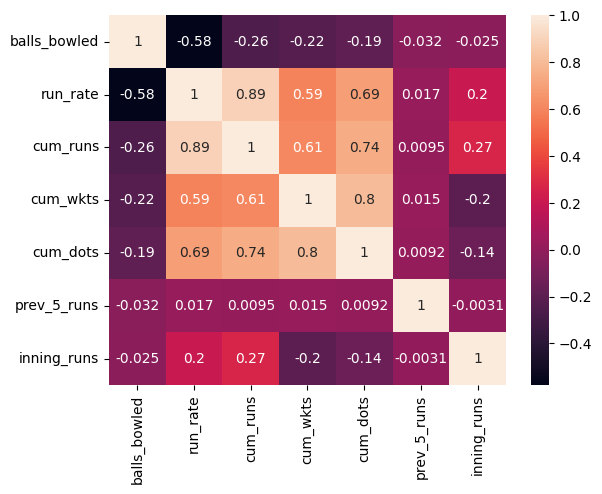

In [ ]:
temp = data[['balls_bowled', 'run_rate', 'cum_runs', 'cum_wkts', 'cum_dots', 'prev_5_runs', 'inning_runs']]

sns.heatmap(temp.corr(), annot=True)

In [ ]:
data.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,cum_wkts,prev_5_runs,prev_5_run_rate,prev_5_boundary,overs,over,balls_left,balls_bowled,run_rate,projected_score
0,829821,2015,2015-05-22,JSCA International Stadium Complex,1,1,Royal Challengers Bangalore,Chennai Super Kings,CH Gayle,V Kohli,...,0,1.0,0.2,0.0,0.1,0,119,1,0.0,0.0
1,829821,2015,2015-05-22,JSCA International Stadium Complex,1,2,Royal Challengers Bangalore,Chennai Super Kings,CH Gayle,V Kohli,...,0,1.0,0.2,0.0,0.2,0,118,2,18.0,360.0
2,829821,2015,2015-05-22,JSCA International Stadium Complex,1,3,Royal Challengers Bangalore,Chennai Super Kings,CH Gayle,V Kohli,...,0,2.0,0.4,0.0,0.3,0,117,3,12.0,240.0
3,829821,2015,2015-05-22,JSCA International Stadium Complex,1,4,Royal Challengers Bangalore,Chennai Super Kings,CH Gayle,V Kohli,...,0,2.0,0.4,0.0,0.4,0,116,4,9.0,180.0
4,829821,2015,2015-05-22,JSCA International Stadium Complex,1,5,Royal Challengers Bangalore,Chennai Super Kings,CH Gayle,V Kohli,...,0,2.0,0.4,0.0,0.5,0,115,5,7.2,144.0


In [ ]:
data.venue.unique()

array(['JSCA International Stadium Complex', 'Wankhede Stadium',
       'MA Chidambaram Stadium, Chepauk', 'Sawai Mansingh Stadium',
       'Dr DY Patil Sports Academy, Mumbai', 'Eden Gardens',
       'Arun Jaitley Stadium, Delhi',
       'Maharashtra Cricket Association Stadium',
       'Narendra Modi Stadium, Ahmedabad', 'Holkar Cricket Stadium',
       'Dubai International Cricket Stadium', 'Feroz Shah Kotla',
       'Punjab Cricket Association IS Bindra Stadium',
       'Punjab Cricket Association IS Bindra Stadium, Mohali',
       'Sharjah Cricket Stadium', 'Rajiv Gandhi International Stadium',
       'Wankhede Stadium, Mumbai',
       'MA Chidambaram Stadium, Chepauk, Chennai',
       'Sardar Patel Stadium, Motera', 'Subrata Roy Sahara Stadium',
       'MA Chidambaram Stadium', 'Sawai Mansingh Stadium, Jaipur',
       'M.Chinnaswamy Stadium', 'Sheikh Zayed Stadium',
       'Saurashtra Cricket Association Stadium', 'Kingsmead',
       'Rajiv Gandhi International Stadium, Uppal',
 

In [ ]:
req_columns = ['match_id', 'season', 'venue', 'innings',
       'batting_team', 'bowling_team', 'inning_runs', 'inning_wkts',
       'cum_runs', 'cum_dots', 'cum_wkts', 'run_rate', 'striker_SR', 'balls_bowled', 'prev_5_runs']

score_data = data[req_columns]

In [ ]:
pip install fuzzywuzzy

In [ ]:
# Merge Similar Venues

from fuzzywuzzy import fuzz

def merge_similar_venues(df, similarity_threshold=70):
    unique_venues = df['venue'].unique()

    merged_venues = {}

    for venue in unique_venues:
        similar_venue_found = False
        for key in merged_venues:
            if fuzz.token_sort_ratio(venue, key) > similarity_threshold:
                similar_venue_found = True
                merged_venues[key].append(venue)
                break

        if not similar_venue_found:
            merged_venues[venue] = [venue]

    for key, values in merged_venues.items():
        df['venue'] = df['venue'].replace(values, key)

    return df

score_data = merge_similar_venues(score_data)


In [ ]:
list(score_data.venue.unique())

['JSCA International Stadium Complex',
 'Wankhede Stadium',
 'MA Chidambaram Stadium, Chepauk',
 'Sawai Mansingh Stadium',
 'Dr DY Patil Sports Academy, Mumbai',
 'Eden Gardens',
 'Arun Jaitley Stadium, Delhi',
 'Maharashtra Cricket Association Stadium',
 'Narendra Modi Stadium, Ahmedabad',
 'Holkar Cricket Stadium',
 'Dubai International Cricket Stadium',
 'Feroz Shah Kotla',
 'Sardar Patel Stadium, Motera',
 'Subrata Roy Sahara Stadium',
 'M.Chinnaswamy Stadium',
 'Sheikh Zayed Stadium',
 'Kingsmead',
 'Rajiv Gandhi International Stadium, Uppal',
 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
 'Nehru Stadium',
 'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh',
 "St George's Park",
 'Brabourne Stadium, Mumbai',
 'SuperSport Park',
 'Newlands',
 'Barabati Stadium',
 'Zayed Cricket Stadium, Abu Dhabi',
 'Shaheed Veer Narayan Singh International Stadium',
 'Buffalo Park',
 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow',
 'New Wanderers 

**Target Encoding**

Encode each venue based on the mean of the target variable (e.g., average runs scored in that venue). This encoding captures the performance associated with each venue.*italicized text*

In [ ]:
# Target Encoding Venue

venue_means = score_data[score_data.innings == 1].groupby(['venue'])['inning_runs'].mean().to_dict()
score_data['venue_avg_score'] = score_data['venue'].map(venue_means)

score_data.venue_avg_score.unique()

array([158.85797439, 169.73127083, 163.50556911, 159.36717901,
       160.30581573, 164.70497574, 174.56458869, 168.4125062 ,
       177.64094806, 160.1196319 , 163.94933999, 163.15508532,
       163.21698113, 149.54054054, 173.13589521, 160.00616246,
       152.09311087, 158.80941313, 157.51554726, 147.32669983,
       198.06487342, 159.0045977 , 179.31443914, 154.49259758,
       141.53751538, 167.86331776, 159.53266332, 146.48113208,
       146.84210526, 148.45983702, 143.95276382, 197.98804781,
       158.05978261, 134.82071713, 161.28455285])

In [ ]:
# Target Encoding Striker: Season

season_means = score_data[score_data.innings == 1].groupby(['season'])['inning_runs'].mean().to_dict()
score_data['season_avg_score'] = score_data['season'].map(season_means)

score_data.season_avg_score.unique()

array([167.71594243, 163.7769189 , 158.05024186, 171.72979716,
       153.92361503, 165.07942865, 183.025752  , 162.17905166,
       172.97031314, 166.51154798, 159.58584237, 168.68750868,
       161.87027325, 156.54454702, 169.87700899, 150.49252243])

In [ ]:
season_means

{'2007/08': 162.1790516631281,
 '2009': 150.4925224327019,
 '2009/10': 165.07942864771059,
 '2011': 153.9236150287713,
 '2012': 158.05024186455586,
 '2013': 156.54454701588665,
 '2014': 163.7769189042582,
 '2015': 167.71594243398073,
 '2016': 161.87027325420922,
 '2017': 166.51154797910365,
 '2018': 172.9703131354209,
 '2019': 168.68750868417396,
 '2020/21': 169.87700898937618,
 '2021': 159.5858423658504,
 '2022': 171.72979715804317,
 '2023': 183.02575200173123}

<Axes: >

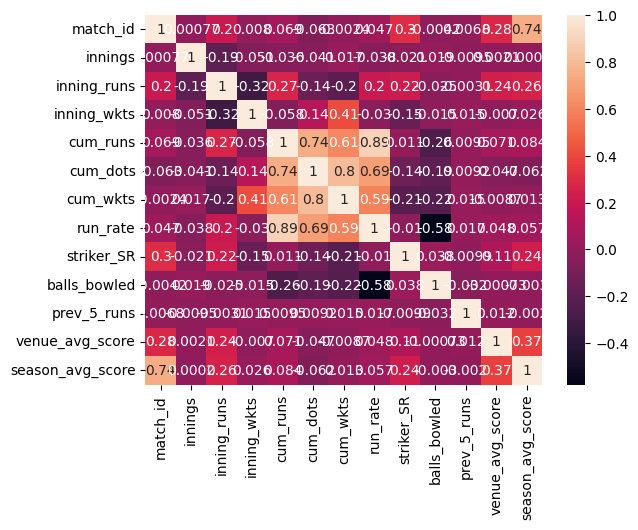

In [ ]:
sns.heatmap(score_data.corr(), annot=True)

In [ ]:
score_data.batting_team.unique()

array(['Royal Challengers Bangalore', 'Chennai Super Kings',
       'Kings XI Punjab', 'Pune Warriors', 'Rajasthan Royals',
       'Lucknow Super Giants', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Punjab Kings', 'Delhi Capitals', 'Gujarat Titans',
       'Rising Pune Supergiant', 'Sunrisers Hyderabad',
       'Delhi Daredevils', 'Gujarat Lions', 'Deccan Chargers',
       'Rising Pune Supergiants', 'Kochi Tuskers Kerala'], dtype=object)

In [ ]:
df_encoded = pd.get_dummies(score_data, columns=['batting_team', 'bowling_team', 'season'])

In [ ]:
df_encoded.head()

,match_id,venue,innings,inning_runs,inning_wkts,cum_runs,cum_dots,cum_wkts,run_rate,striker_SR,...,season_2014,season_2015,season_2016,season_2017,season_2018,season_2019,season_2020/21,season_2021,season_2022,season_2023
0,829821,JSCA International Stadium Complex,1,139,8,0,1,0,0.0,141.259752,...,0,1,0,0,0,0,0,0,0,0
1,829821,JSCA International Stadium Complex,1,139,8,6,1,0,18.0,141.259752,...,0,1,0,0,0,0,0,0,0,0
2,829821,JSCA International Stadium Complex,1,139,8,6,2,0,12.0,141.259752,...,0,1,0,0,0,0,0,0,0,0
3,829821,JSCA International Stadium Complex,1,139,8,6,3,0,9.0,141.259752,...,0,1,0,0,0,0,0,0,0,0
4,829821,JSCA International Stadium Complex,1,139,8,6,4,0,7.2,141.259752,...,0,1,0,0,0,0,0,0,0,0


# Machine Learning

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# Dropping Unnecessary Columns

x = df_encoded.drop(['match_id', 'inning_runs','venue', 'inning_wkts', 'season_avg_score', 'striker_SR'], axis=1)

y = data['inning_runs'].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

x_train = x_train.values
x_test = x_test.values
x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)

In [ ]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((182193, 60), (60731, 60), (182193,), (60731,))

In [ ]:
x.columns

Index(['innings', 'cum_runs', 'cum_dots', 'cum_wkts', 'run_rate',
       'balls_bowled', 'prev_5_runs', 'venue_avg_score',
       'batting_team_Chennai Super Kings', 'batting_team_Deccan Chargers',
       'batting_team_Delhi Capitals', 'batting_team_Delhi Daredevils',
       'batting_team_Gujarat Lions', 'batting_team_Gujarat Titans',
       'batting_team_Kings XI Punjab', 'batting_team_Kochi Tuskers Kerala',
       'batting_team_Kolkata Knight Riders',
       'batting_team_Lucknow Super Giants', 'batting_team_Mumbai Indians',
       'batting_team_Pune Warriors', 'batting_team_Punjab Kings',
       'batting_team_Rajasthan Royals', 'batting_team_Rising Pune Supergiant',
       'batting_team_Rising Pune Supergiants',
       'batting_team_Royal Challengers Bangalore',
       'batting_team_Sunrisers Hyderabad', 'bowling_team_Chennai Super Kings',
       'bowling_team_Deccan Chargers', 'bowling_team_Delhi Capitals',
       'bowling_team_Delhi Daredevils', 'bowling_team_Gujarat Lions',
     

## Linear Regression

In [ ]:
model = LinearRegression()

model.fit(x_train, y_train)

LinearRegression()

In [ ]:
filename = 'lr.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
prediction = model.predict(x_test)
mean_absolute_error(y_test, prediction)

16.99264956573533

In [ ]:
# Function to predict scores by linear regression model:

def score_prediction_LR(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs):

  bat_list = []
  team_encoding_dict = {
    'Chennai Super Kings': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Deccan Chargers': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Delhi Capitals': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Delhi Daredevils': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Gujarat Lions': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Gujarat Titans': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kings XI Punjab': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kochi Tuskers Kerala': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kolkata Knight Riders': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Lucknow Super Giants': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'Mumbai Indians': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Pune Warriors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Punjab Kings': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Rajasthan Royals': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'Rising Pune Supergiant': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Rising Pune Supergiants': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Royal Challengers Bangalore': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Sunrisers Hyderabad': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  }

  season_encoding_dict = {
    'season_2007/08': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2009': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2009/10': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2011': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2012': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2013': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2014': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2015': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2016': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'season_2017': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'season_2018': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'season_2019': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'season_2020/21': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'season_2021': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'season_2022': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'season_2023': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  }

  bat_list = team_encoding_dict[batting_team]
  bowl_list = team_encoding_dict[bowling_team]
  season_list = season_encoding_dict[season]

  temp_array = [innings, cum_runs, cum_dots, cum_wkts, run_rate, balls_bowled, prev_30_runs, venue_means[venue]] + bat_list + bowl_list + season_list

  prediction = model.predict(np.array([temp_array]))


  print('Predicted score by Linear regressor: ',prediction)
  print('Predicted score range: ',prediction - 16, 'to' , prediction + 16)

## XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
XGB = XGBRegressor()

XGB.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
prediction = XGB.predict(x_test)
mean_absolute_error(y_test, prediction)

10.10889669954978

In [ ]:
r2_score(y_test, prediction)

0.8016135167777811

In [ ]:
# Function to predict scores by XG Boost regression model:

def score_prediction_XGB(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs):

  bat_list = []
  team_encoding_dict = {
    'Chennai Super Kings': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Deccan Chargers': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Delhi Capitals': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Delhi Daredevils': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Gujarat Lions': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Gujarat Titans': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kings XI Punjab': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kochi Tuskers Kerala': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kolkata Knight Riders': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Lucknow Super Giants': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'Mumbai Indians': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Pune Warriors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Punjab Kings': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Rajasthan Royals': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'Rising Pune Supergiant': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Rising Pune Supergiants': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Royal Challengers Bangalore': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Sunrisers Hyderabad': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  }

  season_encoding_dict = {
    'season_2007/08': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2009': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2009/10': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2011': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2012': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2013': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2014': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2015': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2016': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'season_2017': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'season_2018': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'season_2019': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'season_2020/21': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'season_2021': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'season_2022': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'season_2023': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  }

  bat_list = team_encoding_dict[batting_team]
  bowl_list = team_encoding_dict[bowling_team]
  season_list = season_encoding_dict[season]

  temp_array = [innings, cum_runs, cum_dots, cum_wkts, run_rate, balls_bowled, prev_30_runs, venue_means[venue]] + bat_list + bowl_list + season_list

  prediction = XGB.predict(np.array([temp_array]))


  print('Predicted score by XG Boost: ',prediction)
  print('Predicted score range: ',prediction - 10, 'to' , prediction + 10)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
RFR=RandomForestRegressor(n_estimators=100)

In [ ]:
RFR.fit(x_train,y_train)

RandomForestRegressor()

In [ ]:
filename = 'rf.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
RFR.score(x_train,y_train)

0.9960652648051744

In [ ]:
prediction=RFR.predict(x_test)
mean_absolute_error (y_test, prediction)

2.488213131130175

In [ ]:
# Function to predict scores by Random Forest regression model:

def score_prediction_RF(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs):

  bat_list = []
  team_encoding_dict = {
    'Chennai Super Kings': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Deccan Chargers': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Delhi Capitals': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Delhi Daredevils': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Gujarat Lions': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Gujarat Titans': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kings XI Punjab': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kochi Tuskers Kerala': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Kolkata Knight Riders': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Lucknow Super Giants': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'Mumbai Indians': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Pune Warriors': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Punjab Kings': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Rajasthan Royals': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'Rising Pune Supergiant': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Rising Pune Supergiants': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Royal Challengers Bangalore': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Sunrisers Hyderabad': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  }

  season_encoding_dict = {
    'season_2007/08': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2009': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2009/10': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2011': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2012': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2013': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2014': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2015': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'season_2016': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'season_2017': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'season_2018': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'season_2019': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'season_2020/21': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'season_2021': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'season_2022': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'season_2023': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  }

  bat_list = team_encoding_dict[batting_team]
  bowl_list = team_encoding_dict[bowling_team]
  season_list = season_encoding_dict[season]

  temp_array = [innings, cum_runs, cum_dots, cum_wkts, run_rate, balls_bowled, prev_30_runs, venue_means[venue]] + bat_list + bowl_list + season_list

  prediction = RFR.predict(np.array([temp_array]))


  print('Predicted score by Random Forest: ',prediction)
  print('Predicted score range: ',prediction - 5, 'to' , prediction + 5)

# Predictions

### MI vs CSK IPL 2019 Final

In [ ]:
# MI vs CSK IPL 2019 Final

batting_team = 'Mumbai Indians'

bowling_team = 'Chennai Super Kings'

venue='Rajiv Gandhi International Stadium, Uppal'

overs = 12.6 # overs 12.6

balls_bowled = 78

season = 'season_2019'

innings=1

cum_runs = 90 # current score 90

cum_wkts = 4 # current wicket 4

cum_dots = 31

run_rate = cum_runs*6/balls_bowled

striker = 'Ishan Kishan'

non_striker = 'KA Pollard'

bowler = 'RA Jadeja'

prev_30_runs = 37 # runs in last 30 balls

prev_30_wkts = 2 # wickets in last 30 balls

prev_30_dots = 8 # dots in last 30 balls

prev_30_boundary = 4 # boundaries in last 30 balls

score_prediction_LR(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

score_prediction_RF(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

score_prediction_XGB(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

Predicted score by Linear regressor:  [160.53317073]
Predicted score range:  [144.53317073] to [176.53317073]
Predicted score by Random Forest:  [164.96]
Predicted score range:  [159.96] to [169.96]
Predicted score by XG Boost:  [149.13823]
Predicted score range:  [139.13823] to [159.13823]


### RCB vs SRH IPL 2016 Final

In [ ]:
# RCB vs SRH IPL 2016 Final => Match ID: 981019

batting_team = 'Sunrisers Hyderabad'

bowling_team = 'Royal Challengers Bangalore'

venue='M Chinnaswamy Stadium, Bengaluru'

overs = 10.6

balls_bowled = 66

season = 'season_2016'

innings=1

cum_runs = 103 # current score

cum_wkts = 2 # current wicket

run_rate = cum_runs * 6 / balls_bowled

cum_dots = 17

striker = 'DA Warner'

non_striker = 'Yuvraj Singh'

bowler = 'CJ Jordan'

prev_30_runs = 44 # runs in last 30 balls

prev_30_wkts = 2 # wickets in last 30 balls

prev_30_dots = 8 # dots in last 30 balls

prev_30_boundary = 6 # boundaries in last 30 balls

score_prediction_LR(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

score_prediction_RF(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

score_prediction_XGB(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

Predicted score by Linear regressor:  [188.78036486]
Predicted score range:  [172.78036486] to [204.78036486]
Predicted score by Random Forest:  [189.57]
Predicted score range:  [184.57] to [194.57]
Predicted score by XG Boost:  [189.35092]
Predicted score range:  [179.35092] to [199.35092]


### MI vs DC IPL 2020 Final

In [ ]:
# MI vs DC IPL 2020 Final => Match ID: 1237181

batting_team = 'Delhi Capitals'

bowling_team = 'Mumbai Indians'

venue='Dubai International Cricket Stadium'

overs = 13.6

balls_bowled = 84

season = 'season_2020/21'

innings=1

cum_runs = 108 # current score

cum_wkts = 3 # current wicket

cum_dots = 30

run_rate = cum_runs * 6 / balls_bowled

striker = 'SS Iyer'

non_striker = 'RR Pant'

bowler = 'NM Coulter-Nile'

prev_30_runs = 43 # runs in last 30 balls

prev_30_wkts = 1 # wickets in last 30 balls

prev_30_dots = 7 # dots in last 30 balls

prev_30_boundary = 5 # boundaries in last 30 balls

score_prediction_LR(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

score_prediction_RF(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

score_prediction_XGB(innings, batting_team, bowling_team,cum_runs,
       cum_dots, cum_wkts, run_rate, striker, balls_bowled, season, venue, prev_30_runs)

Predicted score by Linear regressor:  [172.66769453]
Predicted score range:  [156.66769453] to [188.66769453]
Predicted score by Random Forest:  [173.64]
Predicted score range:  [168.64] to [178.64]
Predicted score by XG Boost:  [169.05838]
Predicted score range:  [159.05838] to [179.05838]
